# 3 Recognising patterns on the move

To be really useful a robot needs to recognise things as it goes along, or ‘on the fly’. In this notebook, you will train a neural network to use a simple MLP classifier to try to identify different shapes on the background. The training samples themselves, images *and* training labels, will be captured by the robot from the simulator background.

We will use the two light sensors to collect the data used to train the network:

- one light sensor will capture the shape image data;
- one light sensor will capture the training class data.

To begin with we will contrive things somewhat to collect the data at specific locations on the background. But then you will explore how we can collect images as the robot moves more naturally within the environment.


*There is quite a lot of provided code in this notebook. You are not necessarily expected to be able to create this sort of code yourself. Instead, try to focus on the process of how various tasks are broken down into smaller discrete steps, as well as how small code fragments can be combined to create "higher level" functions that perform ever more powerful tasks.*

Before continuing, ensure the simulator is loaded and available:


In [1]:
from nbev3devsim.load_nbev3devwidget import roboSim, eds
%load_ext nbev3devsim

<IPython.core.display.Javascript object>

Ev3DevWidget(status='deferring flush until render')

The background image *Simple_Shapes* contains several shapes arranged in a line, including a square, a circle, four equilateral triangles (arrow heads) with different orientations, a diamond and a rectangle.

Just below each shape is a grey square, whose fill colour is used to distinguish between the different shapes.

In [2]:
%sim_magic -b Simple_Shapes -x 600 -y 900

### 3.1 Evaluating the possible training data

In this initial training pass, we will check whether the robot can clearly observe the potential training pairs. Each training pair consists of the actual shape image as well as a solid grey square, where the grey colour is use to represent one of eight (8) different training classes.

The left light sensor will be used to sample the shape image data and the right light sensor will be used to collect the simpler grey classification group pattern.

As we are going to be pulling data into the notebook Python environment from the simulator, ensure the local notebook datalog is cleared:

In [3]:
roboSim.clear_datalog()

The *Simple_Shapes* background we are using in this notebook contains several small regular shapes, with label encoding patterns alongside.

The *x* and *y* locations for sampling the eight different images, along with a designator for each shape, as are follows:

- 200 900 square
- 280 900 equitri1
- 360 900 equitri2
- 440 900 equitri3
- 520 900 equitri4
- 600 900 diamond1

We can now start to collect image data from the robot's light sensors. The `-R` switch runs the program once it has been downloaded to the simulator:

If we print the message `"image_data both"` we can collect data from both the left and the right light sensors at the same time.

In [2]:
%%sim_magic_preloaded -b Simple_Shapes -AR -x 520 -y 900 -O

#Sample the light sensor reading
sensor_value = colorLeft.reflected_light_intensity

# This is essentially a command invocation
# not just a print statement!
print("image_data both")

We can preview the collected image data in the usual way:

In [5]:
roboSim.image_data()

,side,vals,clock
0,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
1,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1


We can also collect consecutive rows of data from the dataframe and decode them as left and right images:

(None, None)

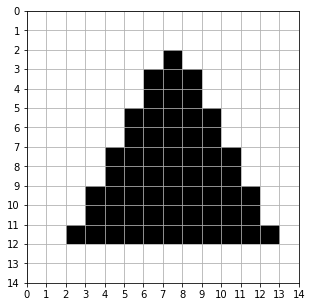

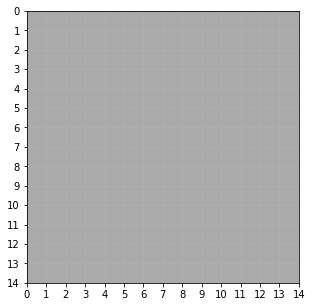

In [6]:
from nn_tools.sensor_data import get_sensor_image_pair
from nn_tools.sensor_data import zoom_img

pair_index = -1

left_img, right_img = get_sensor_image_pair(roboSim.image_data(),
                                            pair_index)
zoom_img(left_img), zoom_img(right_img)

If you don't see a figure image displayed, check that the robot is placed over a figure by reviewing the sensor array display in the simulator. If the image is there, rerun the previous code cell to see if the data is now available. If it isn't, rerun the data collecting magic cell, wait a view seconds, and then try to view the zoomed image display.

We can run the previously downloaded program again from a simple line magic that situates the robot at a specific location and then runs the program to collect the sensor data.

In [7]:
_x = 280

%sim_magic -x $_x -y 900 -RAH

### 3.1.1 Investigating the training data samples

Let's start by seeing if we can collect image data samples for each of the shapes.

In [8]:
from tqdm.notebook import trange
from nbev3devsim.load_nbev3devwidget import tqdma

import time

# Clear the datalog to give us a fresh start
roboSim.clear_datalog()

# x-coordinate for centreline of first shape
_x_init = 200

# Distance between shapes
_x_gap = 80

# Number of shapes
_n_shapes = 6

# y-coordinate for centreline of shapes
_y = 900

# Load in the required background
%sim_magic -b Simple_Shapes

# Generate x coordinate for each shape in turn
for _x in trange(_x_init, _x_init+(_n_shapes*_x_gap), _x_gap):
    
    # Jump to shape and run program to collect data
    %sim_magic -x $_x -y $_y -R
    
    # Wait a short period to allow time for
    # the program to run and capture the sensor data,
    # and for the data to be passed from the simulator
    # to the notebook Python environment
    time.sleep(1)


We should now be able to access multiple image samples via `roboSim.image_data()`, which returns a dataframe containing as many rows as images we scanned:

In [9]:
clean_data_df = roboSim.image_data()
clean_data_df

,side,vals,clock
0,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
1,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
2,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
3,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
4,left,"245,226,225,245,226,225,245,226,225,245,226,22...",2
5,right,"245,226,225,245,226,225,245,226,225,245,226,22...",2
6,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
7,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1
8,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
9,right,"245,226,225,245,226,225,245,226,225,245,226,22...",1


The original sensor data is collected as three channel RGB data. By default, the `get_sensor_image_pair()` function, which extracts a pair of consecutive images from the datalog, converts these to greyscale images:

(None, None)

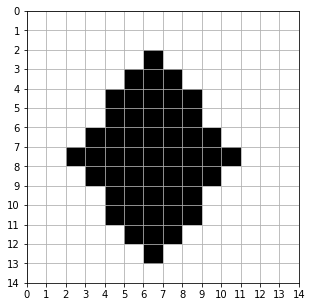

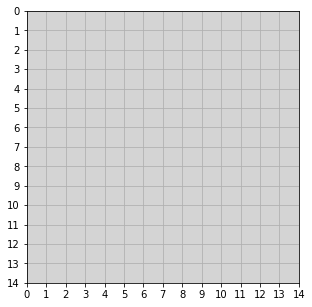

In [10]:
from nn_tools.sensor_data import get_sensor_image_pair

pair_index = -1

left_img, right_img = get_sensor_image_pair(clean_data_df,
                                            pair_index)

zoom_img(left_img), zoom_img(right_img)

We can also filter the dataframe to give us a dataframe containing just the data grabbed from the left hand image sensor:

In [11]:
# The mechanics behind how this line of code
# works are beyond the scope of this module.
# In short, we identify the rows where the
# "side" column value is equal to "left"
# and select just those rows.
clean_left_images_df = clean_data_df[clean_data_df['side']=='left']
clean_left_images_df

,side,vals,clock
0,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
2,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
4,left,"245,226,225,245,226,225,245,226,225,245,226,22...",2
6,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
8,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
10,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1


The shape names and classes are defined as follows in the order they appear going from left to right along the test track. We can also derive a map going the other way, from code to shape.

In [12]:
# Define the classes
shapemap = {'square': 0,
            'right facing triangle': 1,
            'left facing triangle': 2,
            'downwards facing triangle': 3,
            'upwards facing triangle': 4,
            'diamond': 5
           }

codemap = {shapemap[k]:k for k in shapemap}
codemap

{0: 'square',
 1: 'right_tri',
 2: 'left_tri',
 3: 'down_tri',
 4: 'up_tri',
 5: 'diamond'}

### 3.1.2 Counting the number of black pixels in each shape

Ever mindful that we are on the look out for features that might help us distinguish between the different shapes, let's check a really simple measure: the number of black filled pixels in each shape.

If we cast the pixel data for the image in central focus areas of the the image array to a *pandas* *Series*, we can use the *Series* `.value_counts()` method to count the number of each unique pixel value.

*Each column in a `pandas` dataframe is a `pandas.Series` object. Casting a list of data to a `Series` provides us with many convenient tools for manipulating and summarising that data.*

In [13]:
from nn_tools.sensor_data import generate_image, sensor_image_focus
import pandas as pd

for index in range(len(clean_left_images_df)):
    print(index)
    # Get the central focal area of the image
    left_img = sensor_image_focus(generate_image(clean_left_images_df, index))
    
    # Count of each pixel value
    pixel_series = pd.Series(list(left_img.getdata()))
    # The .value_counts() method tallies occurrences
    # of each unique value in the Series
    pixel_counts = pixel_series.value_counts()
    
    # Display the count and the image
    display(codemap[index], left_img, pixel_counts)
    print('\n')

0


'square'

255    147
0       49
dtype: int64



1


'right_tri'

255    145
0       51
dtype: int64



2


'left_tri'

255    145
0       51
dtype: int64



3


'down_tri'

255    143
0       53
dtype: int64



4


'up_tri'

255    136
0       60
dtype: int64



5


'diamond'

255    145
0       51
dtype: int64

Observing the black (`0` value) pixel counts, we see that they do not uniquely identify the shapes. For example, the left and right facing triangles and the diamond all have 51 black pixels. A simple pixel count does not provide a way to distinguish between the shapes.

### 3.1.3 Activity — Using bounding box sizes as a feature for distinguishing between shapes

When we trained a neural network to recognise shape data, we use the dimensions of a bounding box drawn around the fruit as the input features to our network.

Will the bounding box approach used there also allow us to distinguish between the shape images?

Run the following code cell to convert the raw data associated with an image to a data frame, and then prune the rows and columns the edges that only contain white space.

The dimensions of the dataframe, which is to say, the `.shape` of the dataframe, given as the 2-tuple `(rows, columns)`, corresponds to the bounding box of the shape. 

In [14]:
from nn_tools.sensor_data import df_from_image, trim_image

index = -1

# The sensor_image_focus function crops
# to the central focal area of the image array
left_img = sensor_image_focus(generate_image(clean_left_images_df, index))

trimmed_df = trim_image( df_from_image(left_img, show=False), reindex=True)

# dataframe shape
trimmed_df.shape

,0,1,2,3,4,5,6,7,8
0,255,255,255,255,0,255,255,255,255
1,255,255,255,0,0,0,255,255,255
2,255,255,0,0,0,0,0,255,255
3,255,255,0,0,0,0,0,255,255
4,255,0,0,0,0,0,0,0,255
5,0,0,0,0,0,0,0,0,0
6,255,0,0,0,0,0,0,0,255
7,255,255,0,0,0,0,0,255,255
8,255,255,0,0,0,0,0,255,255
9,255,255,255,0,0,0,255,255,255


(11, 9)

Using the above code, or otherwise, find the shape of the bounding box for each shape as captured in the `roboSim.image_data` list.

You may find it useful to use the provided code as the basis of a simple function that will:

- take the index number for a particular image data scan;
- generate the image;
- find the size of the bounding box.

Then you can iterate through all the rows in the `left_images_df` dataset, generate the corresponding image and its bounding box dimensions, and then display the image and the dimensions.

*Hint: you can use a `for` loop defined as `for i in range(len(left_images_df)):` to iterate through each row of the data frame and generate an appropriate index number, `i`, for each row.*

Based on the shape dimensions alone, can you distinguish between the shapes?

In [15]:
# Your code here

*Record your observations here, identifying the bounding box dimensions for each shape (square, circle, equitri1, equitri2, equitri3, equitri4, rect, diamond1). Are the shapes distinguishable from their bounding box sizes?*

#### Example solution

*Click the arrow in the sidebar or run this cell to reveal an example solution.*

Let's start by creating a simple function inspired by the supplied code that will display an image and its bounding box dimensions:

In [16]:
def find_bounding_box(index):
    """Find bounding box for a shape in an image."""
    img = sensor_image_focus(generate_image(clean_left_images_df, index))
    trimmed_df = trim_image( df_from_image(img, show=False), show=False, reindex=True)

    # Show image and shape
    display(img, trimmed_df.shape)

find_bounding_box(0)

(7, 7)

We can then call this function by iterating through each image data record in the `roboSim.image_data` dataset:

In [17]:
for i in range(len(clean_left_images_df)):
    find_bounding_box(i)

(7, 7)

(11, 9)

(11, 9)

(9, 11)

(10, 11)

(11, 9)

Inspecting the results from my run (yours may be slightly different), several of the shapes appear to share the same bounding box dimensions:

- the left and right facing triangles and the diamond have the same dimensions (`(11, 9)`).

The square is clearly separated from the other shapes on the basis of its bounding box dimensions, but the other shapes all have dimensions that may be hard to distinguish between.

### 3.1.4 Decoding the training label image

The grey filled squares alongside the shape images are used to encode a label describing the associated shape.

The grey levels are determined by the following algorithm, in which we use the numerical class values to derive the greyscale value:

In [18]:
from numpy import nan

greymap = {nan: 'unknown'}

# Generate greyscale value
for shape in shapemap:
    key = int(shapemap[shape] * 255/len(shapemap))
    greymap[key] = shape
    
greymap

{nan: 'unknown',
 0: 'square',
 42: 'right_tri',
 85: 'left_tri',
 127: 'down_tri',
 170: 'up_tri',
 212: 'diamond'}

Let's see if we can decode the labels from the solid grey squares.

To to try to make sure we are using actual shape image data, we can can identify images in our training set if *all* the pixels in the right hand image are the same value.

In [19]:
left_img, right_img = get_sensor_image_pair(clean_data_df, -1)

# Generate a set of distinct pixel values
# from the right hand image.
# Return True if there is only one value
# in the set. That is, all the values are the same.
len(set(right_img.getdata())) == 1

True

The following function can be used to generate a greyscale image from a row of the dataframe, find the median pixel value within that image, and then try to decode it. We also return a flag (`uniform`) that identifies if the all the pixels in the right hand encoded label image are the same.

In [20]:
def decode_shape_label(img, background=255):
    """Decode the shape from the greyscale image."""
    # Get the image greyscale pixel data
    # The pandas Series is a convenient representation
    image_pixels = pd.Series(list(img.getdata()))
    
    # Find the median pixel value
    pixels_median = int(image_pixels.median())
    
    shape = None
    code= None
    #uniform = len(set(img.getdata())) == 1
    # There is often more than one way to do it!
    # The following makes use of Series.unique()
    # which identifies the distinct values in a Series
    uniform = len(image_pixels.unique()) == 1
    
    if pixels_median in greymap:
        shape = greymap[pixels_median]
        code = shapemap[greymap[pixels_median]]
        
    return (pixels_median, shape, code, uniform)

We can apply that function to each row of the dataframe by iterating over pairs of rows:

In [21]:
shapes = []

# The number of row pairs is half the number of rows
num_pairs = int(len(clean_data_df)/2)

for i in range(num_pairs):
    
    # Retrieve a pair of images 
    # from the datalog dataframe:
    left_img, right_img = get_sensor_image_pair(roboSim.image_data(), i)
    
    #Decode the label image
    (grey, shape, code, uniform) = decode_shape_label(right_img)
    
    # Add the label to a list of labels found so far
    shapes.append(shape)

    # Display the result of decoding
    # the median pixel value
    print(f"Grey: {grey}; shape: {shape}; code: {code}; uniform: {uniform}")

Grey: 0; shape: square; code: 0; uniform: True
Grey: 42; shape: right_tri; code: 1; uniform: True
Grey: 85; shape: left_tri; code: 2; uniform: True
Grey: 127; shape: down_tri; code: 3; uniform: True
Grey: 170; shape: up_tri; code: 4; uniform: True
Grey: 212; shape: diamond; code: 5; uniform: True


We can also use the `decode_shape_label()` function as part of another function that will return a shape training image and it's associated label from a left and right sensor row pair in the datalog dataframe:

In [22]:
def get_training_data(raw_df, pair_index):
    """Get training image and label from raw data frame."""
    
    # Get the left and right images
    # at specified pair index
    left_img, right_img = get_sensor_image_pair(raw_df,
                                            pair_index)
    response = decode_shape_label(right_img)
    (grey, shape, code, uniform) = response
    return (shape, code, uniform, left_img)

To use the `get_training_data()` function, we pass it the datalog dataframe and the index of the desired image pair:

diamond 5 True


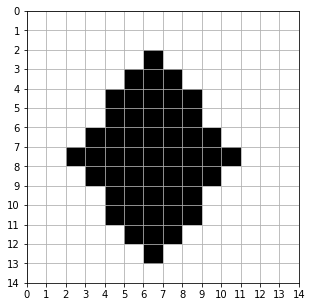

In [23]:
pair_index = -1

# Get the response tuple as a single variable
response = get_training_data(clean_data_df, pair_index)

# Then unpack the tuple
(shape, code, uniform, training_img) = response

print(shape, code, uniform)
zoom_img(training_img)

In summary, we can now:
    
- grab the greyscale training image;
- find the median greyscale value;
- try to decode that value to a shape label / code;
- return the shape label and code associated with that greyscale image, along with an indicator of whether the image is in view via the `uniform` training image array flag;
- label the corresponding shape image with the appropriate label.

## 3.2 Real time data collection

In this section, you will start to explore how to collect data in real time as the robot drives over the images, rather than being teleported directly on top of them.

### 3.2.1 Identifying when the robot is over a pattern in real time

If we want to collect data from the robot as it drives slowly over the images we need to be able to identify when it is passing over the images so we can trigger the image sampling.

The following program will slow drive over the test patterns, logging the reflected light sensor values every so often. Start the program using the simulator *Run* button or the simulator `R` keyboard shortcut.

From the traces on the simulator chart, can you identify   when the robot passes over the images?

*Record your observations here.*

In [24]:
%%sim_magic_preloaded -b Simple_Shapes -x 100 -y 900 -OAc

say("On my way..")

# Start driving forwards slowly
tank_drive.on(SpeedPercent(10), SpeedPercent(10))

count = 1

# Drive forward no further than a specified distance
while int(tank_drive.left_motor.position)<1500:
    
    left_light = colorLeft.reflected_light_intensity_pc
    right_light = colorRight.reflected_light_intensity_pc
    
    # report every fifth pass of the loop
    if not (count % 5):
        print('Light_left: ' + str(left_light))
        print('Light_right: ' + str(right_light))

    count = count + 1

say('All done')

*Based on your observations, describe a strategy you might use to capture image sample data when the test images are largely in view.*

### 3.2.2 Challenge — capturing image data in real time (optional)

Using your observations regarding the reflected light sensor values as the robot crosses the images, or otherwise, write a program to collect image data from the simulator in real time as the robot drives over them.

*Describe your program strategy and record your program design notes here.*

In [70]:
# Your code here

### 3.2.3 Capturing image data in real time

By observation of the reflected light sensor data in the chart, the robot appears to be over the a shape, as the reflected light sensor values drop below about 85%.

From the chart, we might also notice that the training label image (encoded as the solid grey square presented to the right hand sensor) gives distinct readings for each shape.

We can therefore use a drop in the reflected light sensor value to trigger the collection of the image data.

First, let's clear the datalog:

In [25]:
# Clear the datalog to give us a fresh start
roboSim.clear_datalog()

Now we can write a program to drive the robot forwards slowly and collect the image data when it is over an image:

In [39]:
%%sim_magic_preloaded -b Simple_Shapes -x 100 -y 900 -OAR

say("Getting started.")
    
# Start driving forwards slowly
tank_drive.on(SpeedPercent(10), SpeedPercent(10))

# Drive forward no futher than a specified distance
while int(tank_drive.left_motor.position)<1200:
    
    # Sample the right sensor
    sample = colorRight.reflected_light_intensity_pc
    # If we seem to be over a test label,
    # grab the image data into the datalof
    if sample < 85:
        print("image_data both")

say("All done.")

If we review the the images in the datalog, we should see they all contain a fragment at least of the image data (this may take a few moments to run). The following code cell grabs images where the `uniform` flag is set on the encoded label image and adds those training samples to a list (`training_images`):

In [27]:
training_images = []

for i in trange(int(len(roboSim.image_data())/2)):
    
    response = get_training_data(roboSim.image_data(), i)
    
    (shape, code, uniform, training_img) = response
    
    # Likely shape
    if uniform:
        display(shape, training_img)
        training_images.append((shape, code, training_img))

'square'

'square'

'square'

'square'

'right_tri'

'right_tri'

'right_tri'

'left_tri'

'left_tri'

'down_tri'

'down_tri'

'down_tri'

'up_tri'

'up_tri'

'up_tri'

'up_tri'

'diamond'

'diamond'

'diamond'

'diamond'

*Record your own observations here about how "clean" the captured training images are.*

We can cast the list of training images in the convenient form of a *pandas* dataframe:

In [28]:
training_df = pd.DataFrame(training_images,
                           columns=['shape', 'code', 'image'])

training_df.head(3)

,shape,code,image
0,square,0,<PIL.Image.Image image mode=L size=14x14 at 0x...
1,square,0,<PIL.Image.Image image mode=L size=14x14 at 0x...
2,square,0,<PIL.Image.Image image mode=L size=14x14 at 0x...


We can get training image and training label lists as follows:

In [29]:
training_images = training_df['image'].to_list()
training_labels = training_df['code'].to_list()

We are now in a position to try to use the data collected by travelling over the test track to train the neural network.

## 3.2 Training an MLP to recognise the patterns

In an earlier activity, we discovered that the bounding box method we used to distinguish fruits did not provide a set of features that we could use to distinguish the different shapes.

So let's just use a "naive" training approach and just train the network on the 14 x 14 pixels in the centre of each sensor image array.

We can use the `quick_progress_tracked_training()` function we used previously to train an MLP using the scanned image shapes,. We can optionally use the `jiggled=True` parameter to add some variation:


Creating a new MLP...

Topping up...



Number of input features: 196
Number of layers: 3
Number of outputs: 6
Hidden layer sizes: 40
Number of training iterations: 500
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



Confusion matrix:
 [[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 2 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 4 0]
 [0 0 0 0 0 2]]


Training set score: 1.0
Test set score: 1.0



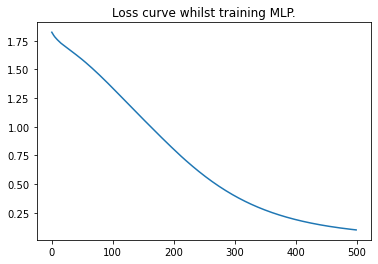

In [30]:
from nn_tools.network_views import quick_progress_tracked_training


# Specify some parameters
hidden_layer_sizes = (40)
max_iterations = 500


# Create a new MLP
MLP = quick_progress_tracked_training(training_images, training_labels,
                                      hidden_layer_sizes=hidden_layer_sizes,
                                      max_iterations=max_iterations,
                                      report=True,
                                      jiggled=False)

We can use the following code cell to randomly select images from the training samples and test the network:

In [31]:
from nn_tools.network_views import predict_and_report_from_image
import random

sample = random.randint(0, len(training_images))
test_image = training_images[sample]
test_label = training_labels[sample]

predict_and_report_from_image(MLP, test_image, test_label)

MLP predicts 5 compared to label 5; classification is True


*Record your observations about how well the network performs.*

## 3.3 Testing the network on a new set of collected data

Let's collect some data again by driving the robot over a second, slightly shorter test track at `y=700` to see if we can recognise the images.

There are no encoded training label images in this track, so we will either have to rely on just the reflected light sensor value to capture legitimate images for us, or we will need to preprocess the images to discard ones that are only partial image captures.

### 3.3.1 Collecting the test data

The following program will stop as soon as the reflected light value from the left sensor drops below 85. How much of the image can we see?

In [32]:
%%sim_magic_preloaded -b Simple_Shapes -x 100 -y 700 -OAR

say('Starting')
# Start driving forwards slowly
tank_drive.on(SpeedPercent(5), SpeedPercent(5))

# Sample the left sensor
sample = colorLeft.reflected_light_intensity_pc
    
# Drive forward no futher than a specified distance
while sample>85:
    sample = colorLeft.reflected_light_intensity_pc

say("All done.")

That's perhaps a bit optimistic for a sensible attempt at image recognition.

However, recalling that black pixel count for the training images ranged from 49 for the square to 60 for one of the equilaterial triangles, we could tag an image as likely to contain a potentially recognisable image if its black pixel count exceeds 45.

To give us some data to work with, let's collect samples for the new test set at `y=700`. First clear the datalog:

In [33]:
# Clear the datalog to give us a fresh start
roboSim.clear_datalog()

And then grab the data:

In [34]:
%%sim_magic_preloaded -b Simple_Shapes -x 100 -y 700 -OAR

say("Starting")

# Start driving forwards slowly
tank_drive.on(SpeedPercent(5), SpeedPercent(5))

# Drive forward no futher than a specified distance
while int(tank_drive.left_motor.position)<800:
    
    # Sample the right sensor
    sample = colorLeft.reflected_light_intensity_pc
    # If we seem to be over a test label,
    # grab the image data into the datalog
    if sample < 85:
        print("image_data both")

say("All done.")

### 3.3.2 Generating the test set

We can now generate a clean test set of images based on a minimum required number of black pixels. The following function grabs the test images and also counts the black pixels in the left image.

In [35]:
def get_test_data(raw_df, pair_index):
    """Get test image and label from raw data frame."""
    
    # Get the left and right images
    # at specified pair index
    left_img, right_img = get_sensor_image_pair(raw_df,
                                            pair_index)
    
    # Get the pixel count
    left_pixel_cnt = pd.Series(list(left_img.getdata())).value_counts()
    count = left_pixel_cnt[0] if 0 in left_pixel_cnt else 0
    
    return (count, left_img)

The following cell creates a filtered list of potentially recognisable images. You may recall seeing a similarly structured code fragment previously when we used the `uniform` flag to select the images. However, in this case, we only save an image to a list if we see the black pixel count decreasing.

Having got a candidate image, the `crop_and_pad_to_fit()` function crops it and tries to place it in the centre of the image array.

In [36]:
from nn_tools.sensor_data import crop_and_pad_to_fit

test_images = []
possible_img = None
possible_count = 0

for i in trange(int(len(roboSim.image_data())/2)):
    (count, left_img) = get_test_data(roboSim.image_data(), i)
    # On the way in to a shape, we have
    # an increasing black pixel count
    if count and count >= possible_count:
        possible_img = left_img
        possible_count = count
    # We're perhaps now on the way out...
    # Do we have a possible shape?
    elif possible_img is not None and possible_count > 45:
        display(possible_count, left_img)
        print('---')
        possible_img = crop_and_pad_to_fit(possible_img)
        test_images.append(possible_img)
        possible_img = None
    # We have now gone passed the image
    elif count < 35:
        possible_count = 0
        
test_images

51

---


51

---


49

---


51

---


[<PIL.Image.Image image mode=L size=14x14 at 0x7F2C9D1C6A90>,
 <PIL.Image.Image image mode=L size=14x14 at 0x7F2CAF487390>,
 <PIL.Image.Image image mode=L size=14x14 at 0x7F2C9D1C69D0>,
 <PIL.Image.Image image mode=L size=14x14 at 0x7F2CB5A46DD0>]

### 3.3.3 Testing the data

Having got our images, we can now try to test them with the MLP.

Recall that the `codemap` dictionary maps from code values to shape name:

'diamond'

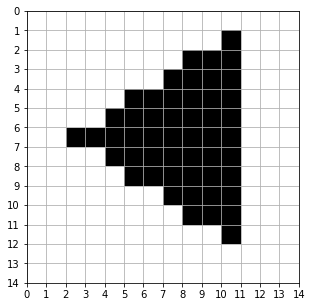

In [38]:
from nn_tools.network_views import class_predict_from_image

# Random sample from the test images
sample = random.randint(0, len(test_images)-1)

test_img = test_images[sample]

prediction = class_predict_from_image(MLP, test_img)

# How did we do?
display(codemap[prediction])
zoom_img(test_img)

### 3.3.4 Save the MLP

Save the MLP so we can use it again:

In [98]:
from joblib import dump

dump(MLP, 'mlp_shapes_14x14.joblib') 

# Load it back
#from joblib import load

#MLP = load('mlp_shapes_14x14.joblib')

['mlp_shapes_14x14.joblib']

## Summary

In this notebook, you have seen how we can collect data in real time from the simulator by sampling images when the robot detects a change in the reflected light levels.

Using a special test track, with paired shape and encoded label images, we were able to collect a set of shape based training patterns that could be used to train an MLP to recognise the shapes.

Investigation of the shape images revealed that simple black pixel counts and bounding box dimensions did not distinguish between the shapes, so we simply trained the network on the raw images.

Running the robot over a test track without and paired encoded label image, we were still able to detect when the robot was over the image based on the black pixel count of the shape image. On testing the MLP  against newly collected and shapes, the neural network was able to correctly classify the collected patterns.

In the next notebook, you will explore how the robot may be able to identify the shapes in real time as part of a multi-agent system working in partnership with  a pattern recognising agent running in the notebook Python environment.